# Description

This notebook was used to process the corpora created in the data_extraction notebooks, find the optimal hyperparameters for LDA, train and fit the optimal LDA models and create timeline graphs. This notebook does this for the selected-sections variant of the CFT dataset.

**Note**: some sections (tokenization and finding optimal hyperparameters) are commented out since the resulting datasets and models are serialized with pickle and can simply be loaded in. If you want to run the processing yourself, simply uncomment these. Be aware that the processing might take some time.

In [1]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation as PUNCTUATION
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import random
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from tqdm.notebook import tqdm
from tqdm import tqdm
from nltk.probability import FreqDist
from collections import Counter

DATA_PATH = "../data"
VIS_PATH = "../visualisations"
model_trf = spacy.load("en_core_web_trf")
model_sm = spacy.load("en_core_web_sm")

c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\packaging\version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


## Load data

In [2]:
data = pd.read_pickle(DATA_PATH + "/processed/dataset_CFT_tokenized.pkl")
data.head()

,filename,date,full_text,selected_sections,full_text tokenized filtered,selected_sections tokenized filtered
0,1347 - EN-Annex II - ToR.pdf,10-03-2016,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,1. \n\nTerms and Definitions \n\n \n\nThe term...,january ref jl myfrontex digital workplace cot...,term definitions term table appear complete ab...
1,1415 - EN-Annex II_Terms of Reference_OP_87_20...,30-03-2016,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,1. General Information \n \n1.1. Overview \n...,annex ii term reference tor frontex data centr...,general information overview subject maintenan...
2,1456 - EN-Annex II TOR-FWC-SPServices2016-19.pdf,30-04-2016,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,1. \n\nTerms and Definitions \n\nFWC \n\nThe t...,ref frontex ah annex ii framework contract sha...,term definitions fwc term table appear complet...
3,1507 - EN-Annex II - Terms of Reference.pdf,07-05-2016,\n \n\n \n \n \n \n \n \n \n\n \n \n \n \n\n ...,1. Background Information \n\nNational (PL) \n...,tender procedure frontex jl courier post servi...,background information national pl eu country ...
4,1556 - EN-Annex II_Terms of Reference_OP_286_2...,27-05-2016,\n\n \n \n \n\n \n\n \n\nAnnex II \n\n \n\n ...,1 \n\nSituation Monitoring and supporting IT s...,annex ii term reference frontex rs purchase di...,situation monitoring support system frontex es...


Text(0.5, 1.0, 'Number of CFT documents per year')

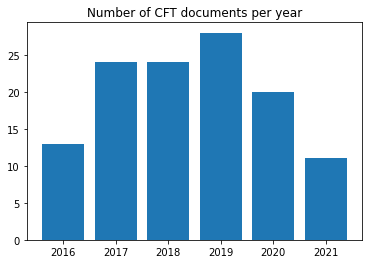

In [3]:
# plot the number of CFT documents per year
count_dict = Counter([x[-1] for x in data["date"].str.split("-")])
plt.bar(count_dict.keys(), count_dict.values())
plt.title("Number of CFT documents per year")

## Tokenization

In [19]:
def tokenize(sample, model_type="sm"):
    """
    Tokenizes and filteres CFT document text. Model type should be
    either sm or trf depending on which spacy model should be used.
    Caution: using the trf model can take excessively long!
    """
    
    if not sample:
        return None
    
    if model_type == "sm":
        model = model_sm
    elif model_type == "trf":
        model = model_trf
    else:
        print("Error invalid model type!")
        return None
    
    tokens = []
    doc = model(sample)
    for token in doc:
        if token.pos_ != "PUNCT":
            token_processed = token.lemma_.lower().strip()
        
            if token_processed not in STOP_WORDS and len(token_processed) > 0:
                if token_processed not in PUNCTUATION:
                    tokens.append(token_processed)        
    return " ".join(tokens)

def filter_tokens(tokenized_text):
    """
    Filters tokens containing digits from a CFT document.
    """
    
    split_text = tokenized_text.split(" ")
    output = []
    for token in split_text:
        if len([char for char in token if char.isdigit()]) == 0:
            output.append(token)
            
    return " ".join(output)

def split_text(text, desired_part_length=100000):
    """
    Splits a text into roughly equal parts of a given length.
    Only splits on whitespace. Used for memory management.
    """
    
    length = len(text)
    n_parts = length // desired_part_length
    steps = length // n_parts

    parts = []
    start = 0 
    end = 0
    for _ in range(n_parts - 1):
        end = end + steps
        # make sure to split on whitespace to not mess up tokenization
        for i in range(end, length):
            if text[i] in [" ", "\n"]:
                end = i
                break

        parts.append(text[start:end])
        start = end

    parts.append(text[start:length])
    return parts

In [ ]:
# # add a new column to the dataset, namely the tokenized and filtered selected_sections of the documents
# tokenized_selected_sections = []
# for ss in tqdm(data["selected_sections"]):
#     length = len(ss)
#     if length > 100000:
#         # split the text for memory management reasons (the spacy models
#         # of large documents use a large amount of memory)
#         parts = split_text(ss)
#         tokenized_parts = [tokenize(part) for part in parts]
#         tokenized = "".join(tokenized_parts)
#     else:
#         tokenized = tokenize(ss)
#     tokenized_selected_sections.append(filter_tokens(tokenized))
    
# data["selected_sections tokenized filtered"] = tokenized_selected_sections

# # save the dataset
# data.to_pickle(DATA_PATH + "/processed/dataset_TENDOC_tokenized.pkl")

## Preprocess data

In [6]:
%%time
# filter datapoints with invalid or missing descriptions
column_name = "selected_sections tokenized filtered"
no_invalid = data[data[column_name].notna()].reset_index(drop=True)
corpus = no_invalid[column_name]

# vectorize data, that is create matrix of word count per document
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(corpus)

# total word counts
word_freq = [np.sum(data_vectorized.toarray()[:,index]) for index in range(len(vectorizer.get_feature_names()))]

Wall time: 32.6 s


## Find optimal hyperparameters

In [5]:
# # for each k in a range of [2-50] train a LDA model and save the log-likelihood,
# # perplexity and U_mass coherence score.
# log_likelihoods = []
# perplexities = []
# coherences = []
# ks = list(range(2, 50))
# for i in tqdm(ks):
#     lda = LatentDirichletAllocation(n_components=i, learning_method='online')
#     data_lda = lda.fit_transform(data_vectorized.toarray())
    
#     coherence = metric_coherence_gensim(
#         measure='u_mass',
#         topic_word_distrib=lda.components_,
#         dtm=data_vectorized.toarray(),
#         vocab=np.array(vectorizer.get_feature_names())
#     )
#     coherences.append(np.mean(coherence))
    
#     log_likelihoods.append(lda.score(data_vectorized))
#     perplexities.append(lda.perplexity(data_vectorized))

  0%|                                                                                           | 0/48 [00:00<?, ?it/s]c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [08:03<00:00, 10.07s/it]

Wall time: 8min 3s


3 highest log likelihoods: [-2065985.16430969 -2074952.70212156 -2075840.17338355]
Associated k's: [7, 4, 11]


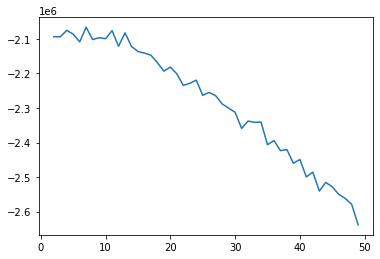

In [6]:
# plt.plot(ks, log_likelihoods)

# top_n = 3
# print(f"{top_n} highest log likelihoods: {np.sort(log_likelihoods)[::-1][:top_n]}")
# print(f"Associated k's: {[ks[i] for i in np.argsort(log_likelihoods)[::-1][:top_n]]}")

3 lowest perplexities: [1243.13165091 1282.1802091  1286.11072505]
Associated k's: [7, 4, 11]


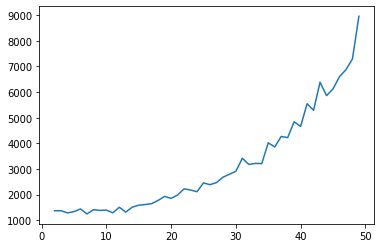

In [7]:
# plt.plot(ks, perplexities)

# top_n = 3
# print(f"{top_n} lowest perplexities: {np.sort(perplexities)[:top_n]}")
# print(f"Associated k's: {[ks[i] for i in np.argsort(perplexities)[:top_n]]}")

10 highest cv coherence: [-0.28887305 -0.32870556 -0.36727877 -0.39121722 -0.41570411 -0.41803999
 -0.4492338  -0.46069658 -0.46976905 -0.49447367]
Associated k's: [2, 4, 13, 8, 41, 18, 39, 36, 24, 32]


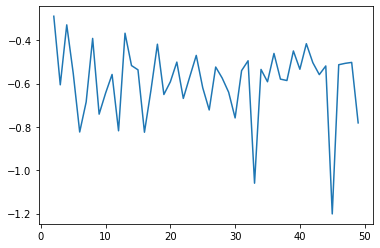

In [8]:
# plt.plot(ks, coherences)

# top_n = 10
# print(f"{top_n} highest cv coherence: {np.sort(coherences)[::-1][:top_n]}")
# print(f"Associated k's: {[ks[i] for i in np.argsort(coherences)[::-1][:top_n]]}")

## Optimal model

In [14]:
%%time
# LDA using optimal k
lda = LatentDirichletAllocation(n_components=10, learning_method='online', verbose=0, max_iter=10)
lda.fit(data_vectorized)

# transform data
data_lda = lda.transform(data_vectorized)

Wall time: 7.82 s


#### Save model

In [67]:
# import pickle
# MODELS_PATH = "../models"

# with open(MODELS_PATH + "/MODELNAME", "wb") as f:
#     pickle.dump(lda, f)

#### Load model

In [7]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scitkitLDA_CFT_selected_sections_k9-1.pkl", "rb") as f:
    lda = pickle.load(f)
    
# transform data
data_lda = lda.transform(data_vectorized)

## Visualize topics

In [8]:
plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne', sort_topics=False)

# uncomment to export the graph as html
# pyLDAvis.save_html(plot, VIS_PATH + '/PLOTNAME.html')

# show plot
plot

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      19.718180 -13.477922       1        1   0.174241
1     -63.120945   3.348280       2        1   4.944261
2     -62.054741 -34.904259       3        1   0.300907
3     -32.442932  18.024561       4        1  49.173872
4       1.370106 -44.290802       5        1   5.615527
5     -38.147903 -15.096533       6        1  17.209343
6     -11.082090 -14.334917       7        1   8.792246
7      -0.320485  16.267361       8        1   0.190561
8     -30.601805 -47.847988       9        1  13.599042, topic_info=            Term         Freq        Total Category  logprob  loglift
4413  management  1050.000000  1050.000000  Default  30.0000  30.0000
6695     service  3690.000000  3690.000000  Default  29.0000  29.0000
3036     frontex  6821.000000  6821.000000  Default  28.0000  28.0000
6725       shall  5092.000000  5092.000000  Default  27.0000  27.0000
6904    software   960.000000   960.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3623     include   228.001139  1469.866893   Topic9  -5.1529   0.1316
1395   condition   172.027741   516.095593   Topic9  -5.4346   0.8965
5805     provide   224.083567  2125.857060   Topic9  -5.1703  -0.2547
5120       order   189.724773   972.164117   Topic9  -5.3367   0.3612
1516    contract   219.816828  2752.768631   Topic9  -5.1895  -0.5324

[654 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
15        4  0.316029       about
15        9  0.316029       about
38        2  0.051211  acceptance
38        4  0.405898  acceptance
38        5  0.001897  acceptance
...     ...       ...         ...
8313      5  0.067249        year
8313      6  0.197790        year
8313      7  0.032965        year
8313      8  0.002637        year
8313      9  0.152957        year

[1590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# name topics
topic_names_k9 = {
    1 : 'fresh food',
    2 : 'border checkpoint',
    3 : 'branding',
    4 : 'software',
    5 : 'organised events',
    6 : 'surveillance',
    7 : 'weather/maps',
    8 : 'crisis management',
    9 : 'local operational support'
}

topic_names_k10 = {
    1 : 'hardware',
    2 : 'staff',
    3 : 'vehicles',
    4 : 'surveillance/information systems',
    5 : 'software',
    6 : 'facilities',
    7 : 'organised events',
    8 : 'weapons',
    9 : 'surveillance',
    10 : 'infrastructure'
}

topic_names = topic_names_k9

Document distribution


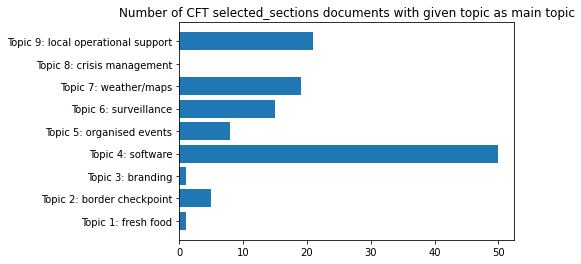

In [15]:
# docments per dominant topic
document_dist = []
for topic_n in range(len(data_lda[0])):
    n_docs = len([i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n])
    document_dist.append(n_docs)
    
plt.barh([f"Topic {key}: {topic_names[key]}" for key in range(1,len(topic_names) + 1)], document_dist)
plt.title("Number of CFT selected_sections documents with given topic as main topic")

In [10]:
def describe_doc(doc_id, word_dist_plot=True, plot=True):
    """
    Gives a description of a certain document. As showing the full
    document would be too much a word frequency graph can be shown instead
    which should give a rough overview of what the document is about.
    The distribution of topics is shown as well.
    """
    
    print("filename:")
    print(data["filename"].iloc[doc_id])
    
    fdist = FreqDist(data["full_text tokenized filtered"].iloc[doc_id].split(" "))
    fig = plt.figure(figsize = (8,4))
    fdist.plot(30)

    sorted_topic = np.sort(data_lda[doc_id])[::-1]
    sorted_topic_index = np.argsort(data_lda[doc_id])[::-1]
    
    print("\nTopics (ranked):")
    topic_strings = []
    topic_weights = []
    for i in range(len(sorted_topic)):
        topic_n = sorted_topic_index[i] + 1
        topic_name = topic_names[topic_n]
        topic_weight = sorted_topic[i]
        
        if plot:
            topic_strings.append(f"Topic {topic_n}: {topic_names[topic_n]}")
            topic_weights.append(topic_weight)
        else:
            print(f"    Topic {topic_n}: {topic_name:<20}{topic_weight:20.9f}")

    if plot:
        plt.figure()
        plt.barh(
            topic_strings[::-1],
            topic_weights[::-1]
        )  

doc_id: 101
filename:
7106 - EN-Annex II Terms of Reference.pdf


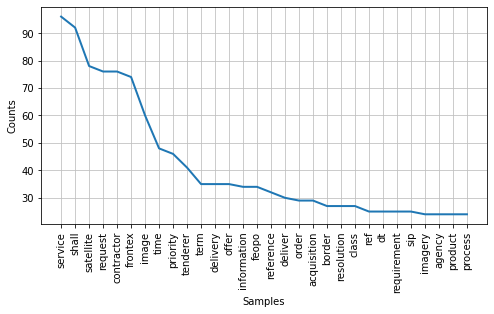


Topics (ranked):


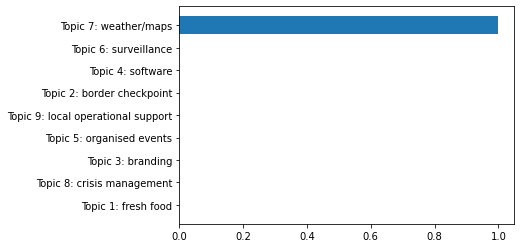

In [12]:
# Sample a random document and print topic
doc_id = np.random.randint(0, len(data["full_text"]) - 1)
print(f"doc_id: {doc_id}")
describe_doc(doc_id)

Topic: 4 - software
Number of documents for this topic: 50

doc_id: 71
filename:
5051 - EN-Annex II Terms of reference.pdf


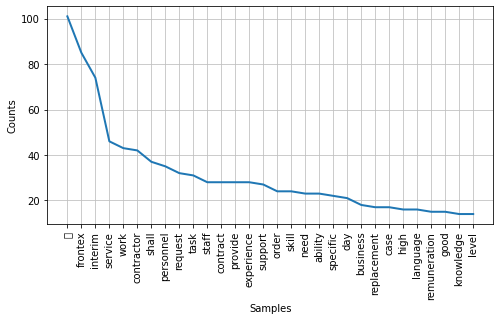


Topics (ranked):


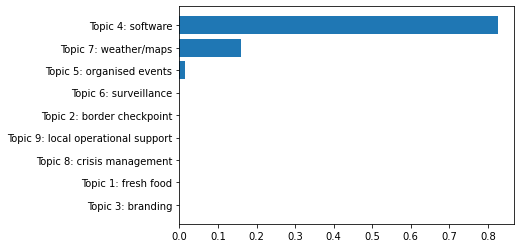

In [13]:
# For a given topic sample a random document
topic_n = 4
print(f"Topic: {topic_n} - {topic_names[topic_n]}")

# all documents with a given topic as dominant topic
topic_docs = [i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n - 1]
print(f"Number of documents for this topic: {len(topic_docs)}\n")

# a random document of the given topic
for doc_id in random.sample(topic_docs, k=1):
    print(f"doc_id: {doc_id}")
    describe_doc(doc_id, plot=True)
    print("="*80)

## Topic distribution per year

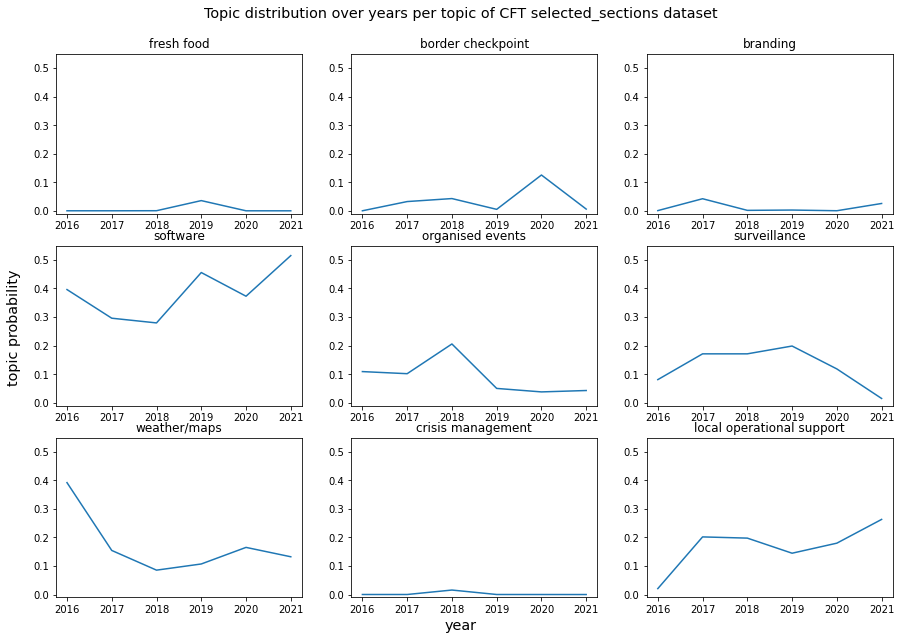

In [8]:
# create topic distribution per year
topic_dist_years = []
for year in [str(y) for y in range(2016, 2022)]:
    ids = data[data["date"].str.contains(year)].index
    topic_dist = np.mean(data_lda[ids], axis=0)
    topic_dist_years.append(topic_dist)
    
    
# plot the distribution of each topic over the years
fig = plt.figure(figsize = (15,10))
fig.text(0.5, 0.93, "Topic distribution over years per topic of CFT selected_sections dataset", ha='center', fontsize="x-large")
fig.text(0.5, 0.08, 'year', ha='center', fontsize="x-large")
fig.text(0.08, 0.5, 'topic probability', va='center', rotation='vertical', fontsize="x-large")
fig.tight_layout(pad=1.0)
for topic_index in range(len(data_lda[0])):
    plt.subplot(3,int(np.ceil(len(data_lda[0])/3)), topic_index+1)
    plt.plot(list(range(2016, 2022)), [x[topic_index] for x in topic_dist_years])
    plt.title(topic_names[topic_index+1])
    plt.ylim(top=0.55, bottom=-0.01)